In [ ]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy import *
%matplotlib inline

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [2]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

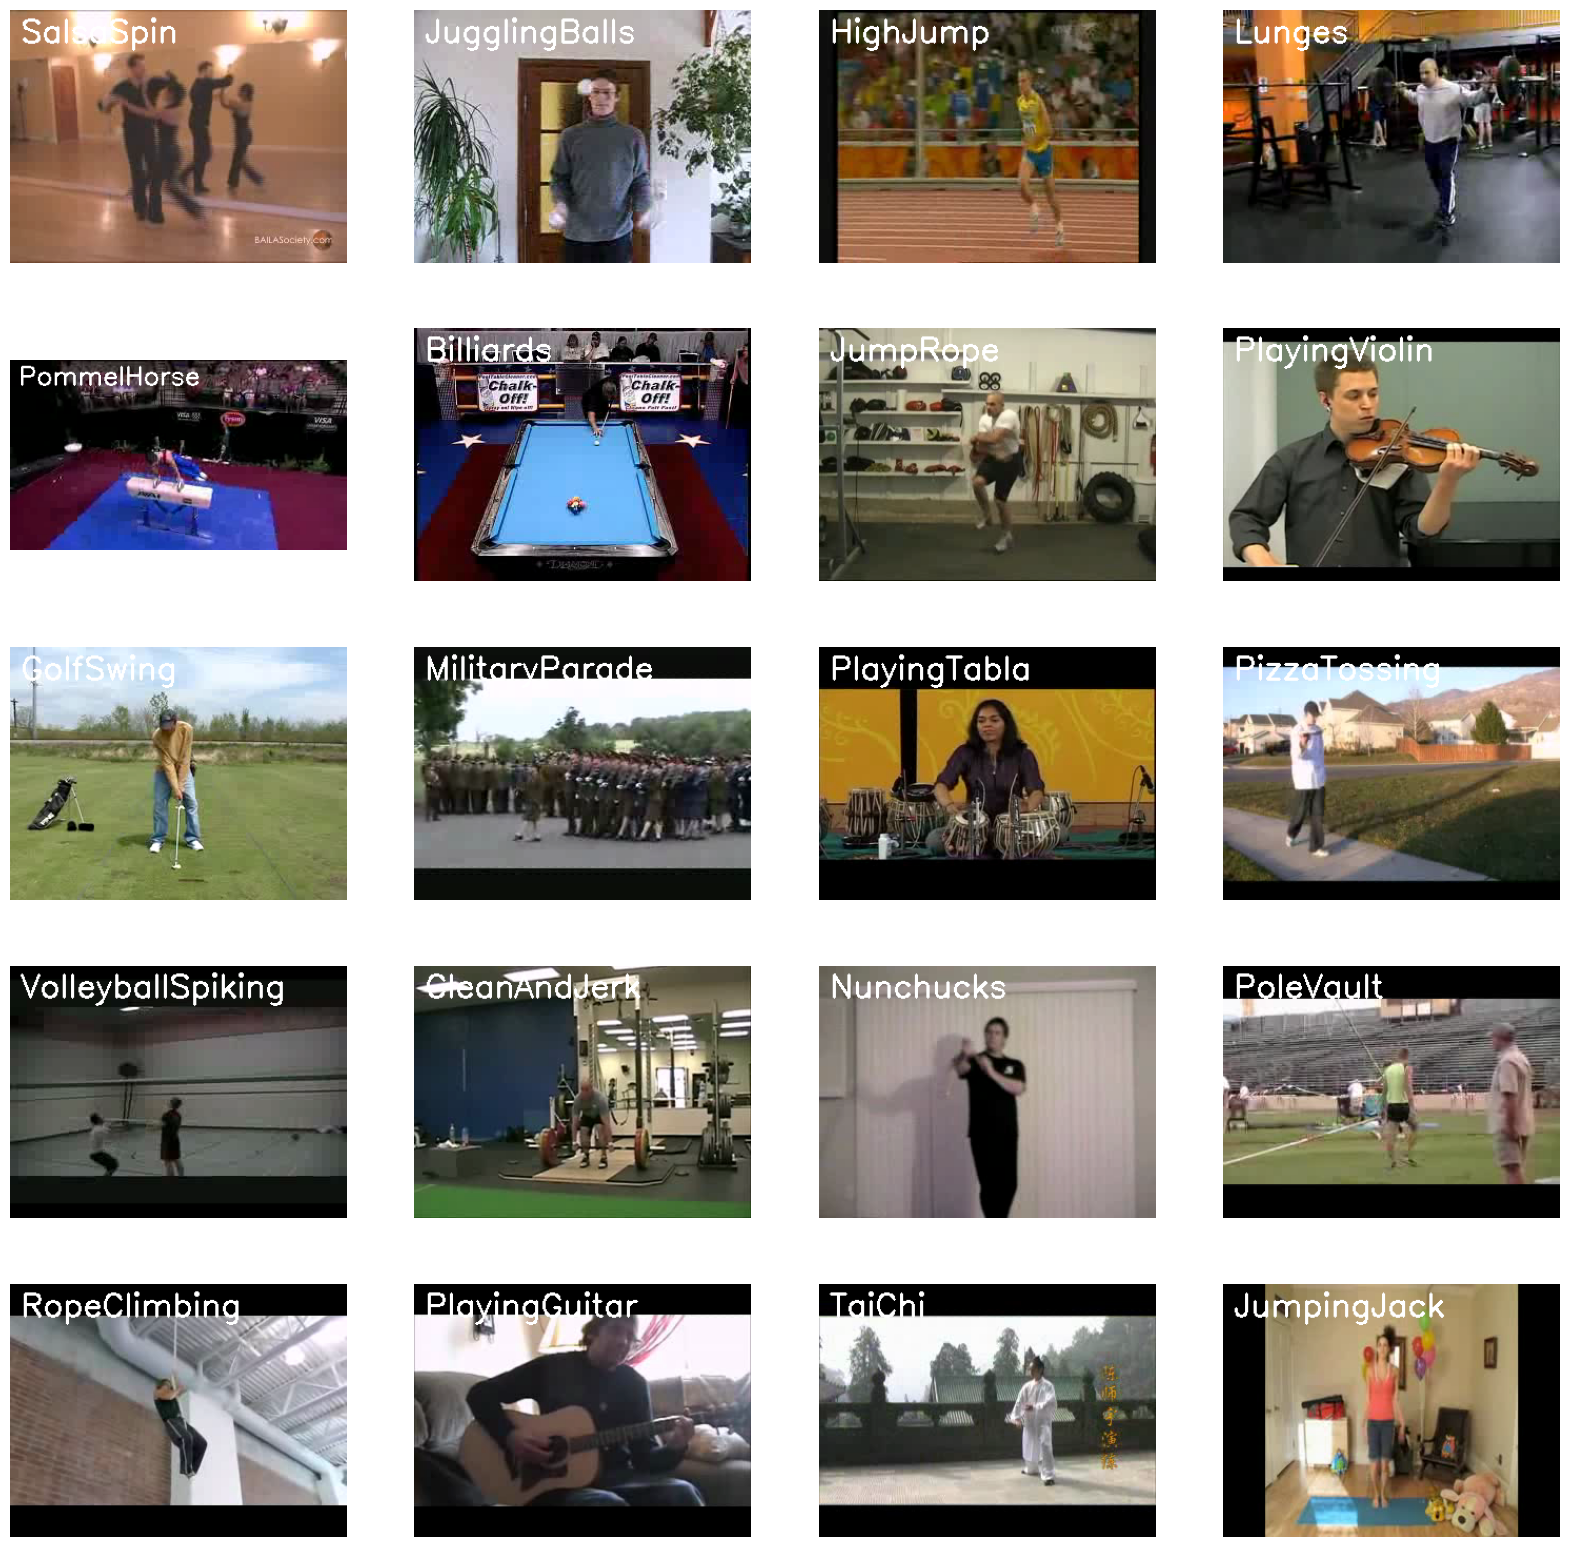

In [ ]:
plt.figure(figsize = (20, 20))

all_classes_names = os.listdir('UCF50')

random_range = random.sample(range(len(all_classes_names)), 20)

for counter, random_index in enumerate(random_range, 1):

    selected_class_Name = all_classes_names[random_index]

    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')

    selected_video_file_name = random.choice(video_files_names_list)

    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')
    
    _, bgr_frame = video_reader.read()

    video_reader.release()

    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

# 2. Preprocess the Dataset

In [ ]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

SEQUENCE_LENGTH = 20

DATASET_DIR = "UCF50"

CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]

In [ ]:
def frames_extraction(video_path):

    frames_list = []
    
    video_reader = cv2.VideoCapture(video_path)

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        success, frame = video_reader.read() 

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        normalized_frame = resized_frame / 255
        
        frames_list.append(normalized_frame)
    
    video_reader.release()

    return frames_list


In [ ]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):

        print(f'Extracting Data of Class: {class_name}')

        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        for file_name in files_list:
            
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)  
    
    return features, labels, video_files_paths

In [ ]:
features, labels, video_files_paths = create_dataset()

one_hot_encoded_labels = to_categorical(labels)

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace


# 3: Split the Data into Train and Test Set

In [ ]:

features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)

# 4. Model 1 : ConvLSTM

In [ ]:
def create_convlstm_model():
    model = Sequential()

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    
    model.summary()
    
    return model

In [ ]:
convlstm_model = create_convlstm_model()

print("Model Created Successfully!")

/Users/akashrana/Documents/Assignments/Computational Perception/Human_Activity_Recognition_using_ConvLSTM/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 20, 62, 62, 4)  │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 20, 31, 31, 4)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 20, 31, 31, 4)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 20, 29, 29, 8)  │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 20, 15, 15, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 15, 15, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 20, 13, 13, 14) │        11,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 20, 7, 7, 14)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 7, 7, 14)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, 20, 5, 5, 16)   │        17,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 20, 3, 3, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2880)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │        11,524 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,524 (173.92 KB)

 Trainable params: 44,524 (173.92 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


In [ ]:
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


## 4.2. Train the model

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 21s 247ms/step - accuracy: 0.2502 - loss: 1.3821 - val_accuracy: 0.5205 - val_loss: 1.4375
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 262ms/step - accuracy: 0.3915 - loss: 1.3774 - val_accuracy: 0.5068 - val_loss: 1.2248
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 256ms/step - accuracy: 0.4716 - loss: 1.1819 - val_accuracy: 0.5753 - val_loss: 1.0341
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 255ms/step - accuracy: 0.5780 - loss: 1.0334 - val_accuracy: 0.6986 - val_loss: 0.9383
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 260ms/step - accuracy: 0.6417 - loss: 0.8522 - val_accuracy: 0.6301 - val_loss: 0.9171
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 253ms/step - accuracy: 0.6966 - loss: 0.7599 - val_accuracy: 0.7123 - val_loss: 0.7135
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 258ms/step - accuracy: 0.6955 - loss: 0.6549 - val_accuracy: 0.7260 - val_loss: 0.6870
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 20s 270ms/step - accuracy: 0.8156 - loss: 0.5315 - val_accu

## 4.3 Evaluate the Trained Model

In [ ]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 385ms/step - accuracy: 0.8166 - loss: 0.4630


## 4.4 Save the model

In [ ]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

convlstm_model.save(model_file_name)

## 4.5 Plot Model Loss and accuracy

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

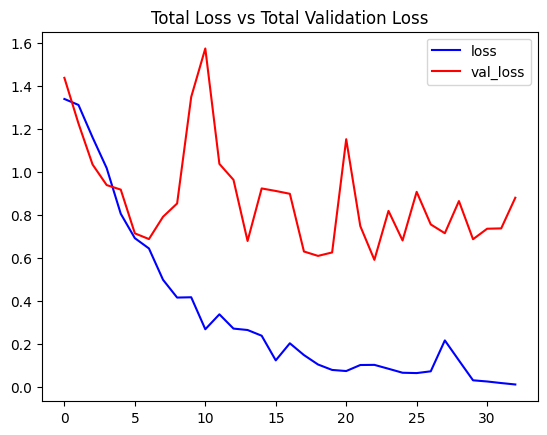

In [ ]:
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

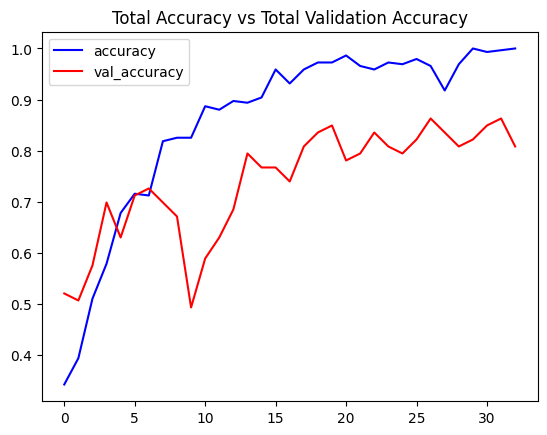

In [ ]:
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

# 4. Model 2 : LRCM

## 4.1 Create a model.

In [ ]:

def create_LRCN_model():
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    model.summary()
    
    return model

In [ ]:
LRCN_model = create_LRCN_model()

print("Model Created Successfully!")

plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

/Users/akashrana/Documents/Assignments/Computational Perception/Human_Activity_Recognition_using_ConvLSTM/.venv/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_3              │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 20, 16, 16, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 20, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 20, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 20, 4, 4, 64)   │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 20, 2, 2, 64)   │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 20, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 20, 64)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,060 (285.39 KB)

 Trainable params: 73,060 (285.39 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!
You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


## 4.2 Compile & Train the model

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.2367 - loss: 1.4282 - val_accuracy: 0.3973 - val_loss: 1.3597
Epoch 2/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.2947 - loss: 1.3585 - val_accuracy: 0.4521 - val_loss: 1.2553
Epoch 3/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.3905 - loss: 1.3477 - val_accuracy: 0.5205 - val_loss: 1.1471
Epoch 4/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.4915 - loss: 1.2115 - val_accuracy: 0.5342 - val_loss: 1.0307
Epoch 5/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.4961 - loss: 1.1521 - val_accuracy: 0.5479 - val_loss: 1.0022
Epoch 6/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.5848 - loss: 0.9886 - val_accuracy: 0.5753 - val_loss: 0.9795
Epoch 7/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.5905 - loss: 0.9446 - val_accuracy: 0.5616 - val_loss: 1.0740
Epoch 8/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.6621 - loss: 0.7606 - val_accuracy: 0.6027 - 

## 4.2 Evaluate the Trained Model

In [ ]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8694 - loss: 0.3018


## 4.3 Save the model

In [ ]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

LRCN_model.save(model_file_name)

## 4.4 Plot the Model's Loss and Accuracy Curves

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

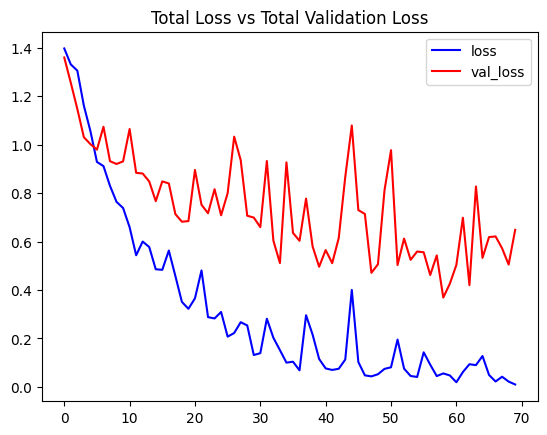

In [ ]:
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

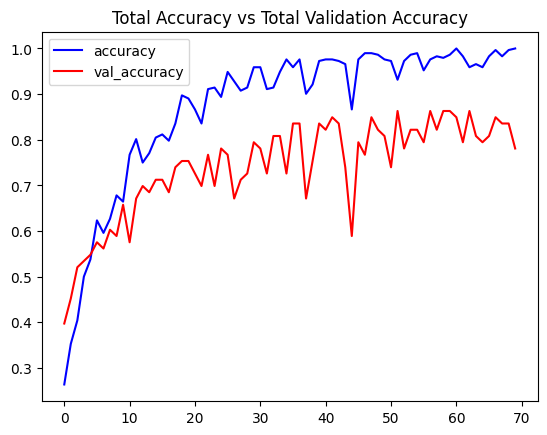

In [ ]:
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')